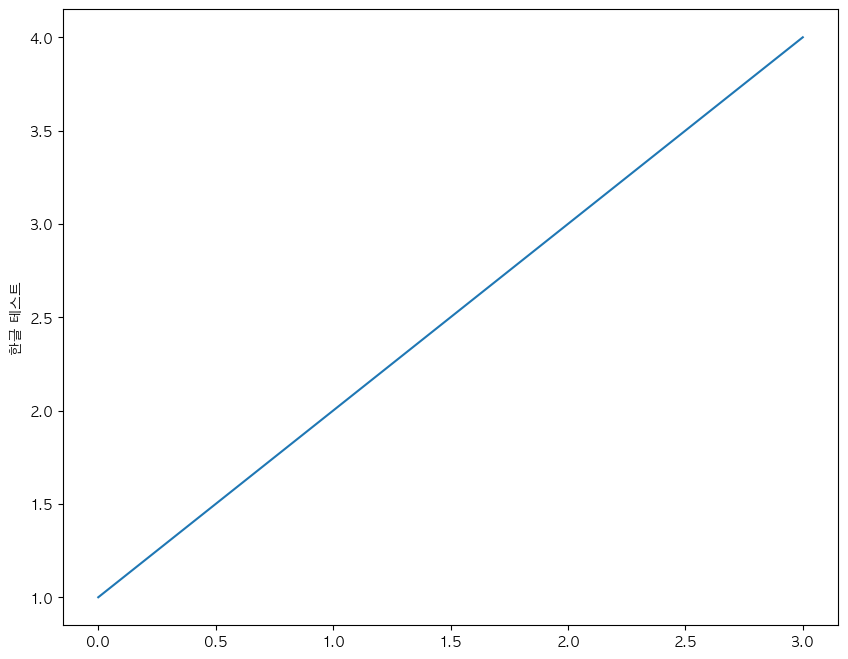

In [2]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

In [6]:
# 3개월 100원 프로모션 데이터 쿼리
promo_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '3개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
ORDER BY 1,2


'''

cur.execute(promo_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,3개월 100원 프로모션,3774,69.634340,67.594065,58.823529,54.107048,49.894012,47.509274
1,2023-12,TMS 프로모션,150,87.333333,84.000000,54.000000,39.333333,38.000000,36.666667
2,2024-01,3개월 100원 프로모션,12299,85.202049,80.787056,60.224408,50.426864,45.524026,42.434344
3,2024-01,TMS 프로모션,960,93.333333,89.270833,62.500000,47.812500,40.833333,38.020833
4,2024-02,3개월 100원 프로모션,10398,85.266397,80.842470,59.982689,49.634545,45.172148,41.594537


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [13]:

# 1. 평균 잔존율 비교
mean_retention = promo_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_retention_df["M3_to_M6_Drop"] = promo_retention_df["M3_PROD_RATE"] - promo_retention_df["M6_PROD_RATE"]
drop_rate = promo_retention_df.groupby("PROMO_GRP_NM")["M3_to_M6_Drop"].mean()
print("\nM3 이후 잔존율 감소율:")
print(drop_rate)



평균 잔존율 비교:
               M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                            
3개월 100원 프로모션     83.701636     78.919138     55.038643     44.108004   
TMS 프로모션          91.211175     87.560903     58.347940     42.239691   

               M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                               
3개월 100원 프로모션     40.223311     37.045737  
TMS 프로모션          36.374879     32.732298  

M3 이후 잔존율 감소율:
PROMO_GRP_NM
3개월 100원 프로모션    21.901403
TMS 프로모션         28.890553
Name: M3_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                       M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                            
2023-12 3개월 100원 프로모션     69.634340     67.594065     58.823529     54.107048   
        TMS 프로모션          87.333333     84.000000     54.000000     39.333333   
2024-01 3개월 100원 프로모션     85.202049     80.787056     60.224408     50.426864   
        TMS 프로모션          93.333333     89.270833     62.500000     47.812500   
2024-02 3개월 100원 프로모션     85.266397     80.842470     59.982689     49.634545   
        TMS 프로모션          93.381468     90.252708     64.741276     47.653430   
2024-03 3개월 100원 프로모션     84.573503     80.084058     59.843347     49.699112   
        TMS 프로모션          92.517815     90.142518     64.370546     49.524941   
2024-04 3개월 100원 프로모션     83.506774     78.627528     58.796387     48.458669   
        TMS 프로모션          91.794872     89.059829     59.487179     45.811966   
2024-05 3개월 10

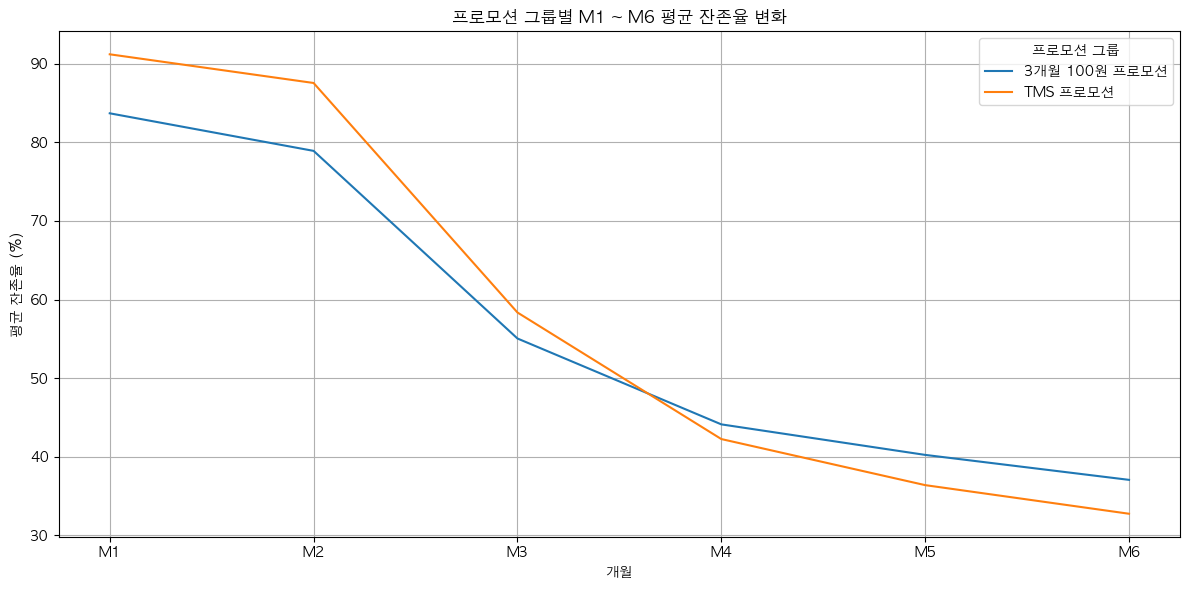

In [12]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

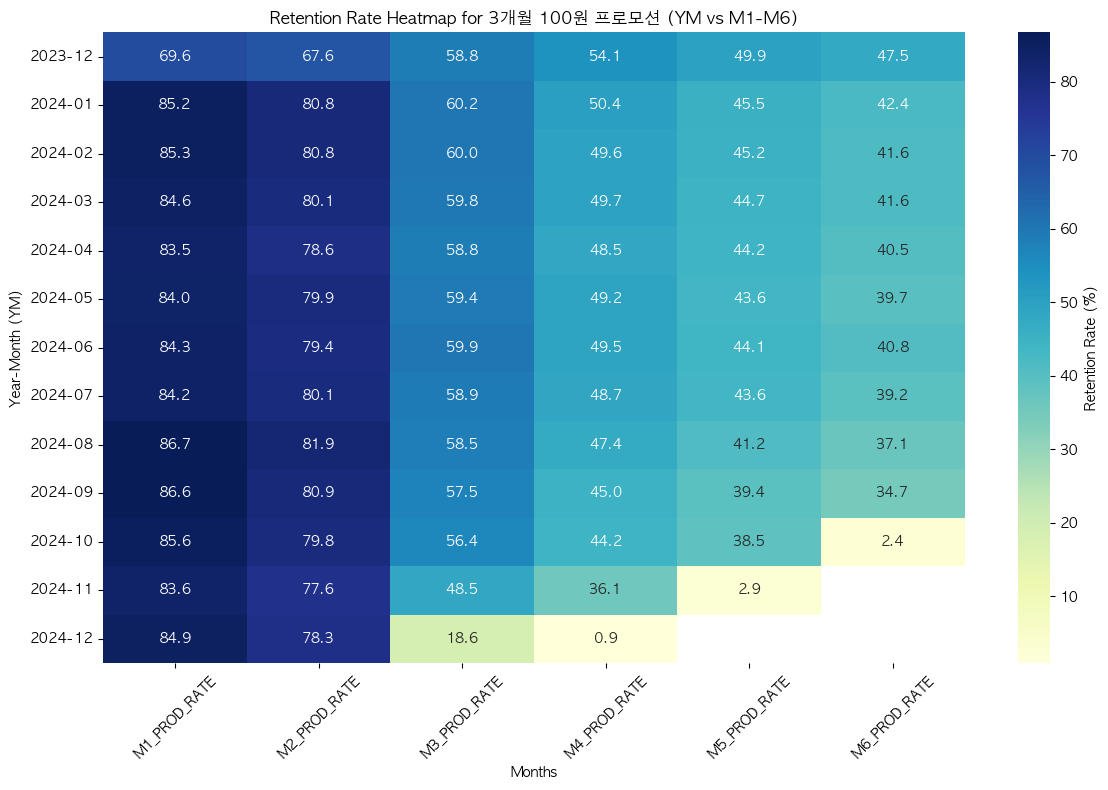

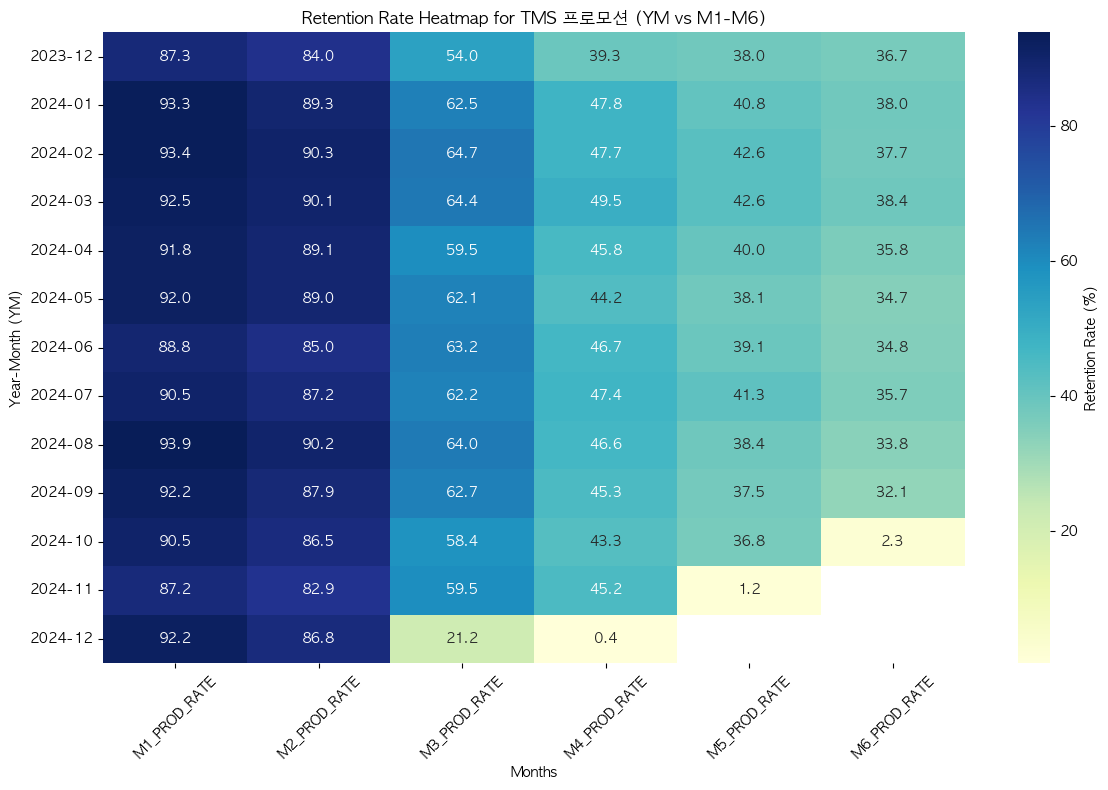

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_retention_df에서 필요한 열만 선택
heatmap_data = promo_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
# 2개월 100원 프로모션 데이터 쿼리
promo_2month_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '2개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
WHERE FST_PROD_CNT > 1000
ORDER BY 1,2
'''

cur.execute(promo_2month_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_2month_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_2month_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,TMS 프로모션,5233,84.349322,41.792471,26.676858,22.262564,20.026753,18.727307
1,2023-12,두달 100원 프로모션,63442,75.260868,45.755178,36.504209,32.410706,30.106239,28.232086
2,2024-01,TMS 프로모션,4696,86.073254,52.427598,35.689949,30.557922,27.704429,25.383305
3,2024-01,두달 100원 프로모션,63406,77.858562,51.006214,40.444122,36.095953,33.525218,31.476516
4,2024-02,TMS 프로모션,4044,86.102868,51.013848,36.894164,30.959446,27.596439,25.395648


In [22]:

# 1. 평균 잔존율 비교
mean_retention = promo_2month_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_2month_retention_df["M2_to_M6_Drop"] = promo_2month_retention_df["M2_PROD_RATE"] - promo_2month_retention_df["M6_PROD_RATE"]
drop_rate = promo_2month_retention_df.groupby("PROMO_GRP_NM")["M2_to_M6_Drop"].mean()
print("\nM2 이후 잔존율 감소율:")
print(drop_rate)


평균 잔존율 비교:
              M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                           
TMS 프로모션         85.939891     46.833541     31.118324     24.588648   
두달 100원 프로모션     77.804577     48.067370     38.105716     32.521472   

              M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                              
TMS 프로모션         21.923086     20.157341  
두달 100원 프로모션     30.117838     28.067017  

M2 이후 잔존율 감소율:
PROMO_GRP_NM
TMS 프로모션        27.839370
두달 100원 프로모션    21.271702
Name: M2_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                      M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                           
2023-12 TMS 프로모션         84.349322     41.792471     26.676858     22.262564   
        두달 100원 프로모션     75.260868     45.755178     36.504209     32.410706   
2024-01 TMS 프로모션         86.073254     52.427598     35.689949     30.557922   
        두달 100원 프로모션     77.858562     51.006214     40.444122     36.095953   
2024-02 TMS 프로모션         86.102868     51.013848     36.894164     30.959446   
        두달 100원 프로모션     78.069293     50.732242     41.186580     37.120395   
2024-03 TMS 프로모션         83.710778     50.013643     36.507503     30.395634   
        두달 100원 프로모션     77.505627     50.574975     40.809186     36.585666   
2024-04 TMS 프로모션         83.684527     46.899458     33.534016     28.145695   
        두달 100원 프로모션     78.176520     49.984021     40.449290     36.505311   
2024-05 TMS 프로모션         8

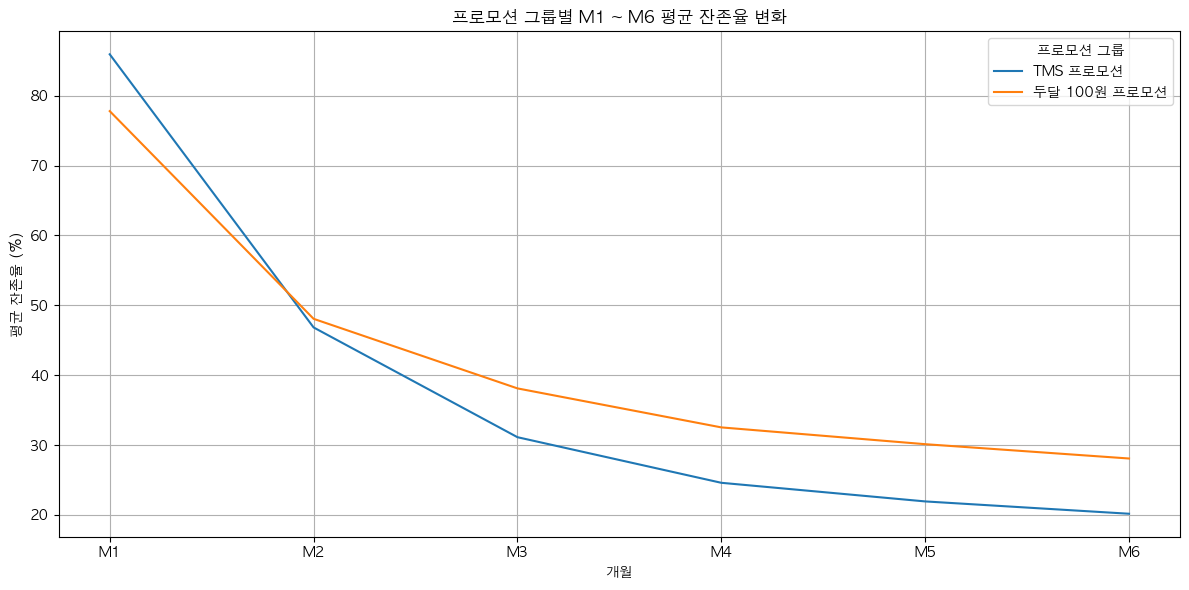

In [23]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_2month_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

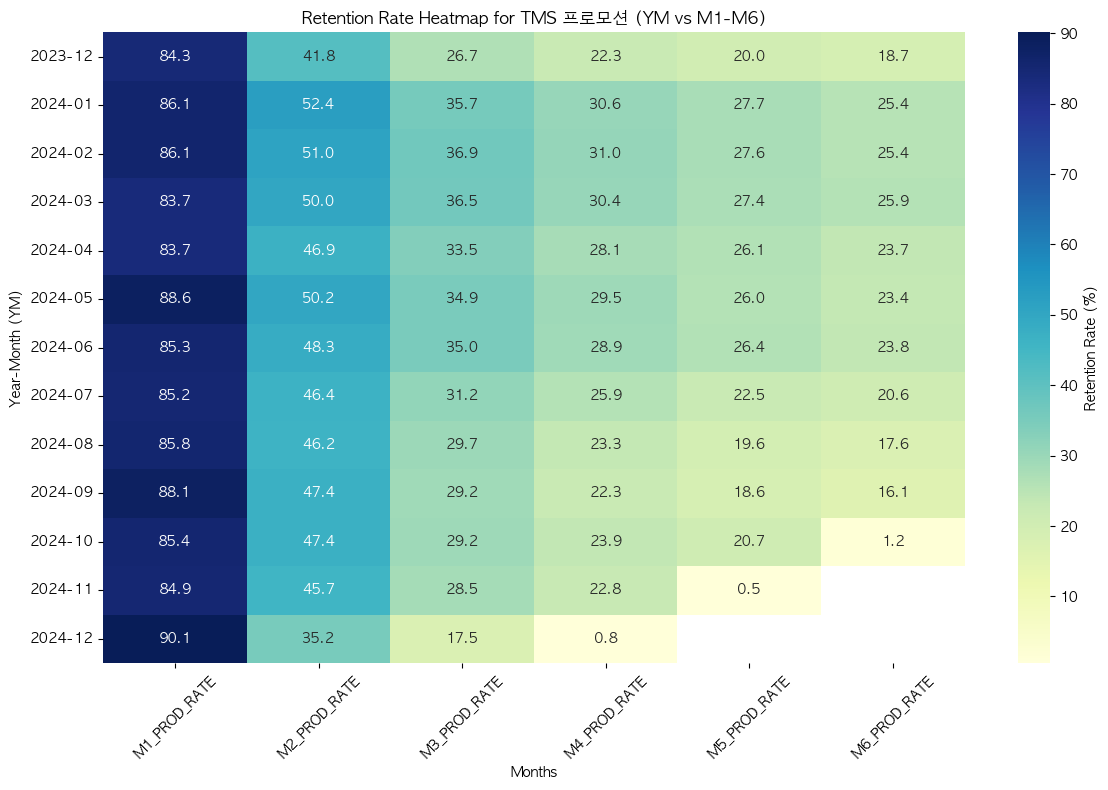

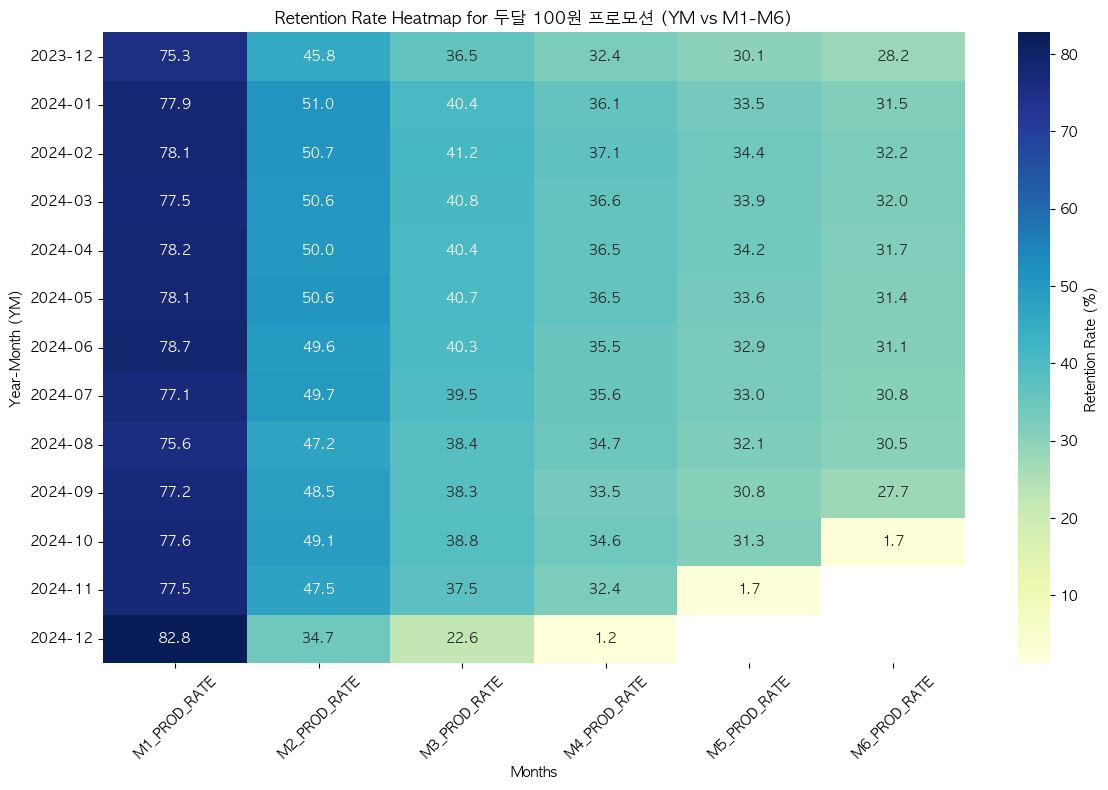

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_2month_retention_df에서 필요한 열만 선택
heatmap_data = promo_2month_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()